# Predicting temperature time-series with the DeepAR built-in algorithm on Amazon SageMaker

http://berkeleyearth.org/data/

The data set we're going to work with holds a daily temperature measure from 1880 to 2014: http://berkeleyearth.lbl.gov/auto/Global/Complete_TAVG_daily.txt

Temperatures are reported as a delta from the 1951-1980 average (8.68°C).

## Download and pre-process data set

In [1]:
!wget http://berkeleyearth.lbl.gov/auto/Global/Complete_TAVG_daily.txt

# Remove header lines (starting with a %), empty lines and lines with only spaces
!grep -v -e '^%\|^$\|^\ *$' Complete_TAVG_daily.txt > temps.txt
!head -10 temps.txt

--2018-02-08 17:53:25--  http://berkeleyearth.lbl.gov/auto/Global/Complete_TAVG_daily.txt
Resolving berkeleyearth.lbl.gov (berkeleyearth.lbl.gov)... 128.3.29.26
Connecting to berkeleyearth.lbl.gov (berkeleyearth.lbl.gov)|128.3.29.26|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2614107 (2.5M) [text/plain]
Saving to: ‘Complete_TAVG_daily.txt’

Complete_TAVG_daily 100%[===================>]   2.49M  2.69MB/s    in 0.9s    

2018-02-08 17:53:26 (2.69 MB/s) - ‘Complete_TAVG_daily.txt’ saved [2614107/2614107]

  1880.001     1880     1     1        1      -0.808
  1880.004     1880     1     2        2      -0.670
  1880.007     1880     1     3        3      -0.740
  1880.010     1880     1     4        4      -0.705
  1880.012     1880     1     5        5      -0.752
  1880.015     1880     1     6        6      -0.810
  1880.018     1880     1     7        7      -0.710
  1880.021     1880     1     8        8      -0.767
  1880.023     1880     1     9       

In [2]:
minYear  = 1880
maxYear  = 2014
avg_temp = 8.68

# Our model will predict temperature for the next 'prediction_length' days
prediction_length = 30

In [3]:
import csv, boto3, json, sagemaker
import numpy as np

In [4]:
f = open('temps.txt', 'r')
data = csv.reader(f,delimiter=' ')

dataset={}
x=[]
y=[]
count=1
prevYear=0

for row in data:
        # Remove empty strings caused by multiple spaces between columns
        row = filter(None, row)
        
        year=row[1]
        temp=float(row[5])+avg_temp
         
        # Data for plotting
        # x list=counter, y list=temperature
        x.append(count)
        y.append(float(temp))
        count=count+1
        
        # Data for training
        # dictionary: key=year, value=list of ordered daily temperatures
        if (year != prevYear):
            dataset[year]=[]
            prevYear=year
        dataset[year].append(float(temp))

In [5]:
nb_samples_per_year = list(map(lambda x: len(x), (dataset[str(year)] for year in range(minYear, maxYear+1))))
nb_samples_per_year = np.unique(nb_samples_per_year).tolist()
assert nb_samples_per_year == [365, 366]

## Plot data set

Number of samples: 49308


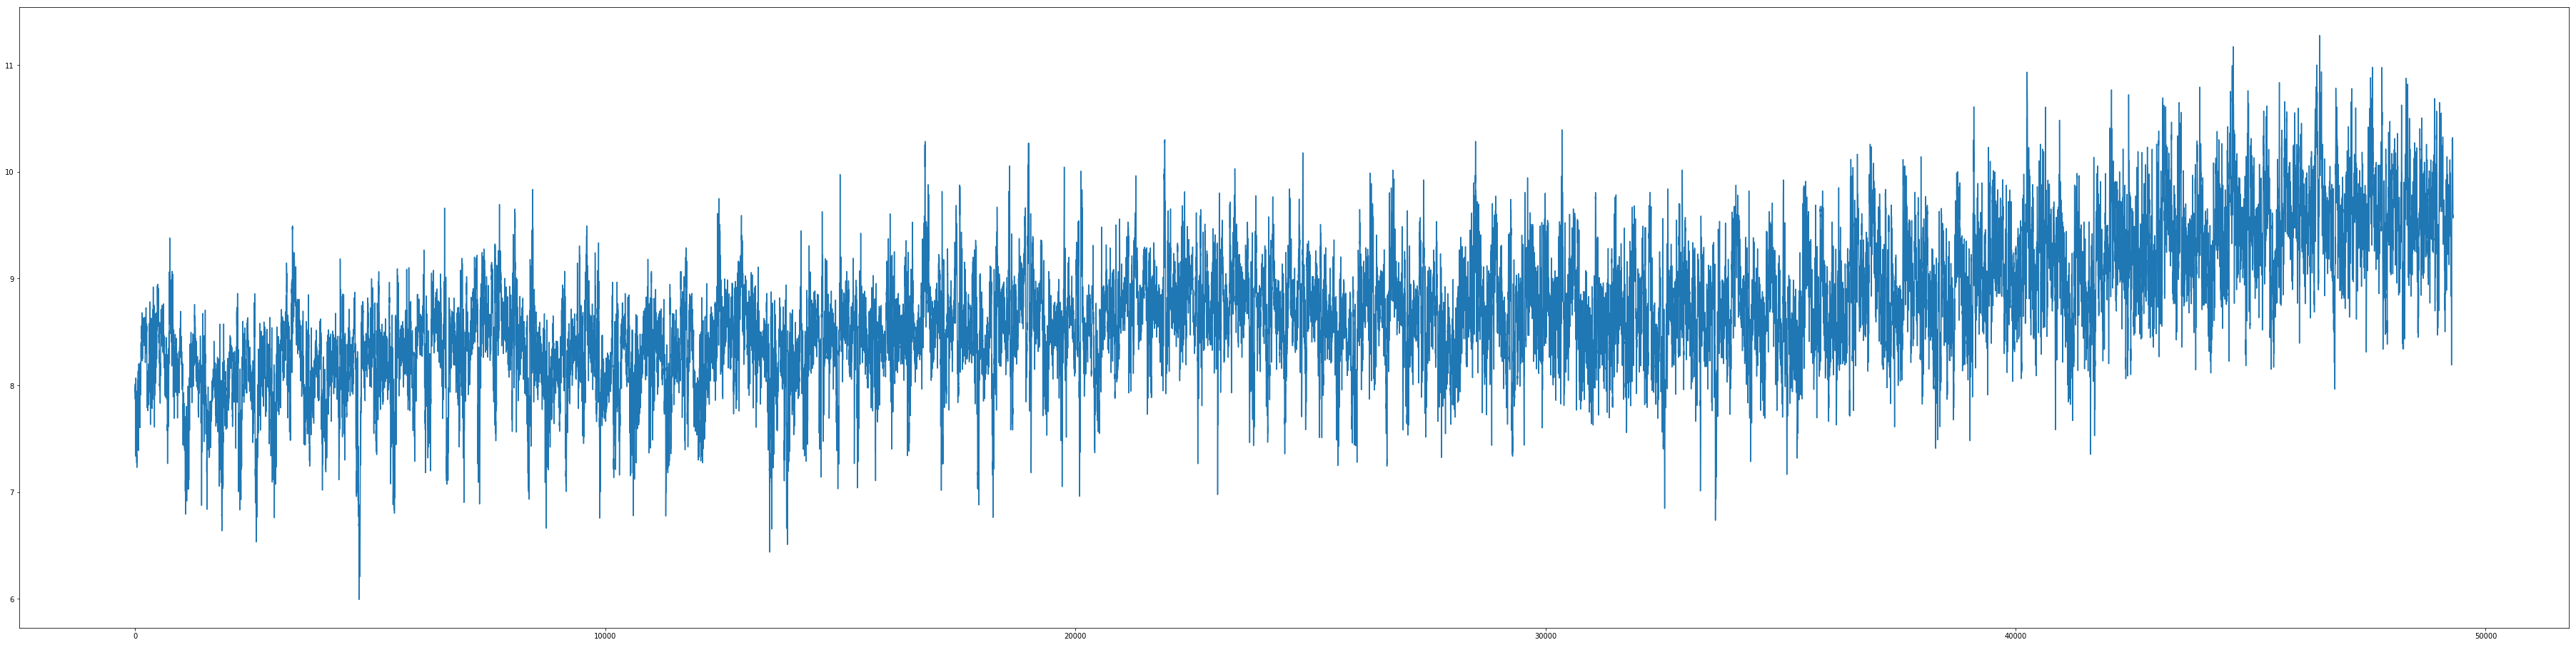

In [6]:
import matplotlib.pyplot as plt

nbSamples=len(x)
print('Number of samples: %d' % nbSamples)

fig=plt.figure(figsize=(64, 16))
plt.plot(x,y)
plt.show()

## Prepare training set and test set

In [7]:
# According to https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html
# - remove the last 'prediction_length' points from each time series
# - use the full data set for testing
# - no need to shuffle the training set: dictionaries are not ordered :)

trainingSet = dataset.copy()
trainingSet[year] = { year: dataset[year][:-prediction_length] for year in dataset.keys() }
testSet = dataset.copy()

In [8]:
train_key      = 'deepar_training.json'
test_key       = 'deepar_test.json'

def writeDataset(filename, data): 
    file=open(filename,'w')
    for year in data.keys():
        # One JSON sample per line
        line = "\"start\":\"{}-01-01 00:00:00\",\"target\":{}".format(year,data[year])
        file.write('{'+line+'}\n')

writeDataset(train_key, trainingSet)        
writeDataset(test_key, testSet)

NameError: name 'train_key' is not defined

In [ ]:
#!head -1 deepar_training.json

## Upload training set and test set to S3

In [ ]:
bucket         = 'jsimon-sagemaker-us'
prefix         = 'sagemaker/deepar-daily-temperature'

train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')
output_prefix  = '{}/{}'.format(prefix, 'output')

In [ ]:
sagemaker_session = sagemaker.Session()
role              = sagemaker.get_execution_role()
region            = boto3.Session().region_name

train_path  = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path   = sagemaker_session.upload_data(test_key,  bucket=bucket, key_prefix=test_prefix)
output_path = 's3://{}/{}'.format(bucket, output_prefix)

print(train_path)
print(test_path)
print(output_path)

## Configure training job

In [ ]:
containers = {
    'us-east-1': '522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:latest',
    'us-east-2': '566113047672.dkr.ecr.us-east-2.amazonaws.com/forecasting-deepar:latest',
    'us-west-2': '156387875391.dkr.ecr.us-west-2.amazonaws.com/forecasting-deepar:latest',
    'eu-west-1': '224300973850.dkr.ecr.eu-west-1.amazonaws.com/forecasting-deepar:latest'
}

image_name = containers[region]

In [ ]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.8xlarge',
    base_job_name='daily-temperature',
    output_path=output_path
)

In [ ]:
# https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html

hyperparameters = {
    "time_freq": 'D', # daily series
    "context_length": prediction_length,
    "prediction_length": prediction_length, # number of data points to predict
    "num_cells": "40",
    "num_layers": "2",
    "likelihood": "gaussian",
    "epochs": "250",
    "mini_batch_size": "32",
    "learning_rate": "0.00001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10" # stop if loss hasn't improved in 10 epochs
}

estimator.set_hyperparameters(**hyperparameters)

## Run training job

In [ ]:
print(train_path)
print(test_path)
print(output_path)

data_channels = {"train": train_path, "test": test_path}

In [ ]:
%%time

estimator.fit(inputs=data_channels)

## Deploy model

In [ ]:
%%time

job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

predictor = sagemaker.predictor.RealTimePredictor(
    endpoint_name, 
    sagemaker_session=sagemaker_session, 
    content_type="application/json")

## Build JSON-formatted prediction request

In [ ]:
q1 = '0.1'         # compute p10 quantile
q2 = '0.9'         # compute p90 quantile
num_samples = 100  # predict 100 sample series
    
def buildPredictionData(year, data):
    year_temps = data[str(year)]
    s = {"start": "{}-01-01 00:00:00".format(year), "target": year_temps}
    series = []
    series.append(s)
    configuration = {
        "output_types": ["mean", "quantiles", "samples"],
        "num_samples": num_samples,
        "quantiles": [q1, q2]
    }
    http_data = {
        "instances": series, 
        "configuration": configuration
    }
    return json.dumps(http_data)

## Get predicted series from response

In [ ]:
def getPredictedSeries(result):
    import random
    json_result = json.loads(result)
    y_data      = json_result['predictions'][0]
    y_mean      = y_data['mean']
    y_q1        = y_data['quantiles'][q1]
    y_q2        = y_data['quantiles'][q2]
    y_sample    = y_data['samples'][random.randint(0, num_samples)]

    #print("Mean: %s\n" % y_mean)
    #print("Quartile %s: %s\n" % (q1, y_q1))
    #print("Quartile %s: %s\n" % (q2, y_q2))
    return y_mean, y_q1, y_q2, y_sample

## Plot predicted series and ground truth

In [ ]:
def plotSeries(result, truth=False, truth_data=None, truth_label=None):
    x = range(0,prediction_length)
    y_mean, y_q1, y_q2, y_sample = getPredictedSeries(result)
    plt.gcf().clear()
    mean_label,   = plt.plot(x, y_mean, label='mean')
    q1_label,     = plt.plot(x, y_q1, label=q1)
    q2_label,     = plt.plot(x, y_q2, label=q2)
    sample_label, = plt.plot(x, y_sample, label='sample')

    if truth:
        ground_truth, = plt.plot(x, truth_data, label=truth_label)
        plt.legend(handles=[ground_truth, q2_label, mean_label, q1_label, sample_label])
    else:
        plt.legend(handles=[q2_label, mean_label, q1_label, sample_label])
    plt.yticks(np.arange(5.0, 12.0, 0.5))
    plt.show()

## Example: predict temperature for the last 'prediction_length' days and compare to ground truth

In [ ]:
year = 1984 # “He who controls the past controls the future. He who controls the present controls the past.”

prediction_data = buildPredictionData(year, trainingSet)

result = predictor.predict(prediction_data).encode('utf-8')

plotSeries(result, 
           truth=True, 
           truth_data=testSet[str(year)][-prediction_length:], 
           truth_label='truth')

## Example: predict temperature for the next 'prediction_length' days

In [ ]:
# Predict temperature for the next 'prediction_length' days of 2018
year = 2018
year_temps={}
year_temps[str(year)] = np.random.normal(9, 1.5, 90).tolist()

prediction_data = buildPredictionData(year, year_temps)
result = predictor.predict(prediction_data).encode('utf-8')
plotSeries(result)

## Clean up

In [ ]:
print(job_name)
sm = boto3.client('sagemaker')
#sm.delete_endpoint(EndpointName=job_name)
#sm.delete_endpoint_config(EndpointConfigName=job_name)
#sm.delete_model(ModelName=job_name)